##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Composing Decision Forest and Neural Network models

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/decision_forests/tutorials/model_composition_colab"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/decision-forests/blob/main/documentation/tutorials/model_composition_colab.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/decision-forests/blob/main/documentation/tutorials/model_composition_colab.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/decision-forests/documentation/tutorials/model_composition_colab.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://keras.io/guides/functional_api"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />Keras Functional API</a>
  </td>
</table>

## Introduction

Welcome to the *model composition tutorial* for TensorFlow Decision Forests
(TF-DF). This notebook shows you how to compose multiple decision forest and
neural network models together using a common preprocessing layer and the
[Keras functional API](https://keras.io/guides/functional_api/).

You might want to compose models together to improve predictive performance
(ensembling), to get the best of different modeling technologies (heterogeneous
model ensembling), to train different part of the model on different datasets
(e.g. pre-training), or to create a stacked model (e.g. a model
operates on the predictions of another model).

This tutorial covers an advanced use case of model composition using the
Functional API. You can find examples for simpler scenarios of model composition
in the "feature preprocessing" section of this [tutorial](beginner_colab.ipynb)
and in the "using a pretrained text embedding" section of this
[tutorial](intermediate_colab.ipynb).

Here is the structure of the model you'll build:

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 KB 2.2 MB/s eta 0:00:00


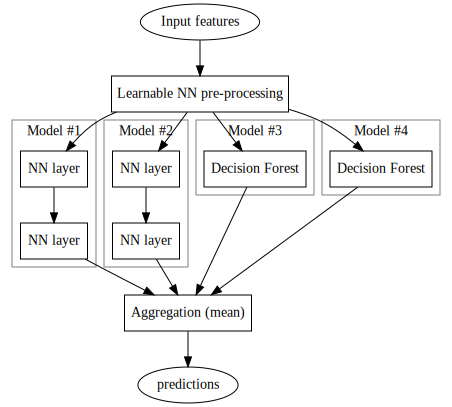

In [2]:
#@title

!pip install graphviz -U --quiet

from graphviz import Source

Source("""
digraph G {
  raw_data [label="Input features"];
  preprocess_data [label="Learnable NN pre-processing", shape=rect];

  raw_data -> preprocess_data

  subgraph cluster_0 {
    color=grey;
    a1[label="NN layer", shape=rect];
    b1[label="NN layer", shape=rect];
    a1 -> b1;
	label = "Model #1";
  }

   subgraph cluster_1 {
    color=grey;
    a2[label="NN layer", shape=rect];
    b2[label="NN layer", shape=rect];
    a2 -> b2;
	label = "Model #2";
  }

  subgraph cluster_2 {
    color=grey;
    a3[label="Decision Forest", shape=rect];
	label = "Model #3";
  }

  subgraph cluster_3 {
    color=grey;
    a4[label="Decision Forest", shape=rect];
	label = "Model #4";
  }

  preprocess_data -> a1;
  preprocess_data -> a2;
  preprocess_data -> a3;
  preprocess_data -> a4;

  b1  -> aggr;
  b2  -> aggr;
  a3 -> aggr;
  a4 -> aggr;

  aggr [label="Aggregation (mean)", shape=rect]
  aggr -> predictions
}
""")

Your composed model has three stages:

1.  The first stage is a preprocessing layer composed of a neural network and
    common to all the models in the next stage. In practice, such a
    preprocessing layer could either be a pre-trained embedding to fine-tune, or
    a randomly initialized neural network.
2.  The second stage is an ensemble of two decision forest and two neural
    network models.
3.  The last stage averages the predictions of the models in the second stage.
    It does not contain any learnable weights.

The neural networks are trained using the
[backpropagation algorithm](https://developers.google.com/machine-learning/glossary#backpropagation)
and gradient descent. This algorithm has two important properties: (1) The layer
of neural network can be trained if its receives a loss gradient (more
precisely, the gradient of the loss according to the layer's output), and (2)
the algorithm "transmits" the loss gradient from the layer's output to the
layer's input (this is the "chain rule"). For these two reasons, Backpropagation
can train together multiple layers of neural networks stacked on top of each
other.

In this example, the decision forests are trained with the
[Random Forest](https://developers.google.com/machine-learning/glossary#random-forest)
(RF) algorithm. Unlike Backpropagation, the training of RF does not "transmit"
the loss gradient to from its output to its input. For this reasons, the
classical RF algorithm cannot be used to train or fine-tune a neural network
underneath. In other words, the "decision forest" stages cannot be used to train
the "Learnable NN pre-processing block".

1.  Train the preprocessing and neural networks stage.
2.  Train the decision forest stages.

## Install TensorFlow Decision Forests

Install TF-DF by running the following cell.

In [3]:
!pip install tensorflow_decision_forests -U --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 75.3 MB/s eta 0:00:00


[Wurlitzer](https://pypi.org/project/wurlitzer/) is needed to display
the detailed training logs in Colabs (when using `verbose=2` in the model constructor).

In [4]:
!pip install wurlitzer -U --quiet

## Import libraries

In [5]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import matplotlib.pyplot as plt

## Dataset

You will use a simple synthetic dataset in this tutorial to make it easier to
interpret the final model.

In [6]:
def make_dataset(num_examples, num_features, seed=1234):
  np.random.seed(seed)
  features = np.random.uniform(-1, 1, size=(num_examples, num_features))
  noise = np.random.uniform(size=(num_examples))

  left_side = np.sqrt(
      np.sum(np.multiply(np.square(features[:, 0:2]), [1, 2]), axis=1))
  right_side = features[:, 2] * 0.7 + np.sin(
      features[:, 3] * 10) * 0.5 + noise * 0.0 + 0.5

  labels = left_side <= right_side
  return features, labels.astype(int)

Generate some examples:

In [7]:
make_dataset(num_examples=5, num_features=4)

(array([[-0.6169611 ,  0.24421754, -0.12454452,  0.57071717],
        [ 0.55995162, -0.45481479, -0.44707149,  0.60374436],
        [ 0.91627871,  0.75186527, -0.28436546,  0.00199025],
        [ 0.36692587,  0.42540405, -0.25949849,  0.12239237],
        [ 0.00616633, -0.9724631 ,  0.54565324,  0.76528238]]),
 array([0, 0, 0, 1, 0]))

You can also plot them to get an idea of the synthetic pattern:

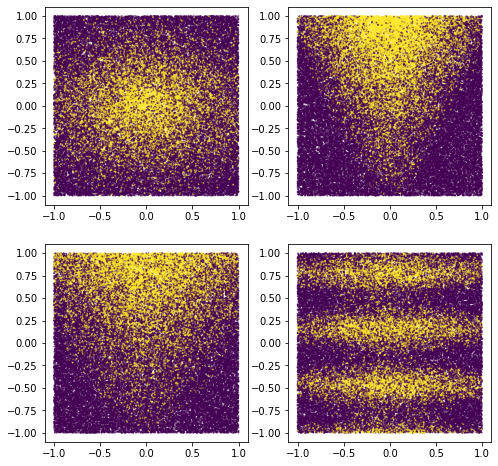

In [8]:
plot_features, plot_label = make_dataset(num_examples=50000, num_features=4)

plt.rcParams["figure.figsize"] = [8, 8]
common_args = dict(c=plot_label, s=1.0, alpha=0.5)

plt.subplot(2, 2, 1)
plt.scatter(plot_features[:, 0], plot_features[:, 1], **common_args)

plt.subplot(2, 2, 2)
plt.scatter(plot_features[:, 1], plot_features[:, 2], **common_args)

plt.subplot(2, 2, 3)
plt.scatter(plot_features[:, 0], plot_features[:, 2], **common_args)

plt.subplot(2, 2, 4)
plt.scatter(plot_features[:, 0], plot_features[:, 3], **common_args)

Note that this pattern is smooth and not axis aligned. This will advantage the neural network models. This is because it is easier for a neural network than for a decision tree to have round and non aligned decision boundaries.

On the other hand, we will train the model on a small datasets with 2500 examples. This will advantage the decision forest models. This is because decision forests are much more efficient, using all the available information from the examples (decision forests are "sample efficient").

Our ensemble of neural networks and decision forests will use the best of both worlds.

Let's create a train and test `tf.data.Dataset`:

In [9]:
def make_tf_dataset(batch_size=64, **args):
  features, labels = make_dataset(**args)
  return tf.data.Dataset.from_tensor_slices(
      (features, labels)).batch(batch_size)


num_features = 10

train_dataset = make_tf_dataset(
    num_examples=2500, num_features=num_features, batch_size=100, seed=1234)
test_dataset = make_tf_dataset(
    num_examples=10000, num_features=num_features, batch_size=100, seed=5678)

## Model structure

Define the model structure as follows:

In [10]:
# Input features.
raw_features = tf.keras.layers.Input(shape=(num_features,))

# Stage 1
# =======

# Common learnable pre-processing
preprocessor = tf.keras.layers.Dense(10, activation=tf.nn.relu6)
preprocess_features = preprocessor(raw_features)

# Stage 2
# =======

# Model #1: NN
m1_z1 = tf.keras.layers.Dense(5, activation=tf.nn.relu6)(preprocess_features)
m1_pred = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(m1_z1)

# Model #2: NN
m2_z1 = tf.keras.layers.Dense(5, activation=tf.nn.relu6)(preprocess_features)
m2_pred = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(m2_z1)


# Model #3: DF
model_3 = tfdf.keras.RandomForestModel(num_trees=1000, random_seed=1234)
m3_pred = model_3(preprocess_features)

# Model #4: DF
model_4 = tfdf.keras.RandomForestModel(
    num_trees=1000,
    #split_axis="SPARSE_OBLIQUE", # Uncomment this line to increase the quality of this model
    random_seed=4567)
m4_pred = model_4(preprocess_features)

# Since TF-DF uses deterministic learning algorithms, you should set the model's
# training seed to different values otherwise both
# `tfdf.keras.RandomForestModel` will be exactly the same.

# Stage 3
# =======

mean_nn_only = tf.reduce_mean(tf.stack([m1_pred, m2_pred], axis=0), axis=0)
mean_nn_and_df = tf.reduce_mean(
    tf.stack([m1_pred, m2_pred, m3_pred, m4_pred], axis=0), axis=0)

# Keras Models
# ============

ensemble_nn_only = tf.keras.models.Model(raw_features, mean_nn_only)
ensemble_nn_and_df = tf.keras.models.Model(raw_features, mean_nn_and_df)

Use /tmp/tmpn_2mmfh6 as temporary training directory


Use /tmp/tmpqxjspdiv as temporary training directory


Before you train the model, you can plot it to check if it is similar to the
initial diagram.

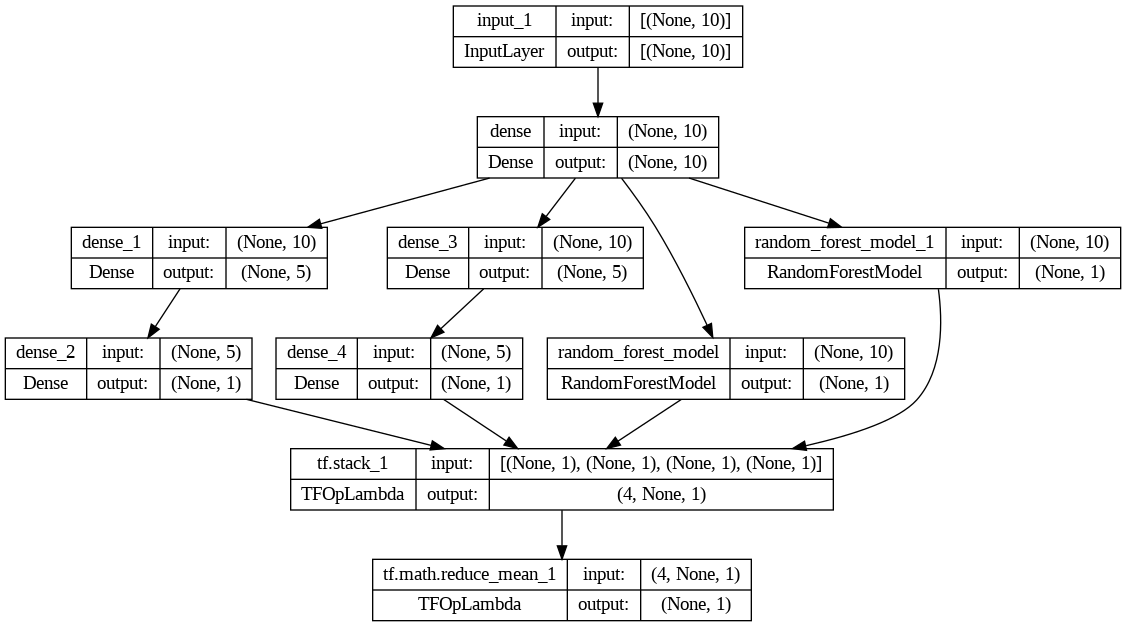

In [11]:
from keras.utils.vis_utils import plot_model

plot_model(ensemble_nn_and_df, to_file="/tmp/model.png", show_shapes=True)

## Model training

First train the preprocessing and two neural network layers using the
backpropagation algorithm.

In [12]:
%%time
ensemble_nn_only.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"])

ensemble_nn_only.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
25/25 [==============================] - 2s 16ms/step - loss: 0.7034 - accuracy: 0.5112 - val_loss: 0.6741 - val_accuracy: 0.5809
Epoch 2/20
25/25 [==============================] - 0s 16ms/step - loss: 0.6611 - accuracy: 0.6052 - val_loss: 0.6395 - val_accuracy: 0.6692
Epoch 3/20
25/25 [==============================] - 0s 10ms/step - loss: 0.6285 - accuracy: 0.6888 - val_loss: 0.6122 - val_accuracy: 0.7148
Epoch 4/20
25/25 [==============================] - 0s 18ms/step - loss: 0.6018 - accuracy: 0.7328 - val_loss: 0.5898 - val_accuracy: 0.7325
Epoch 5/20
25/25 [==============================] - 0s 8ms/step - loss: 0.5796 - accuracy: 0.7464 - val_loss: 0.5713 - val_accuracy: 0.7378
Epoch 6/20
25/25 [==============================] - 0s 11ms/step - loss: 0.5610 - accuracy: 0.7484 - val_loss: 0.5561 - val_accuracy: 0.7393
Epoch 7/20
25/25 [==============================] - 0s 11ms/step - loss: 0.5452 - accuracy: 0.7504 - val_loss: 0.5431 - val_accuracy: 0.7396
Epoch 8/20
25/

Let's evaluate the preprocessing and the part with the two neural networks only:

In [13]:
evaluation_nn_only = ensemble_nn_only.evaluate(test_dataset, return_dict=True)
print("Accuracy (NN #1 and #2 only): ", evaluation_nn_only["accuracy"])
print("Loss (NN #1 and #2 only): ", evaluation_nn_only["loss"])

100/100 [==============================] - 0s 2ms/step - loss: 0.4321 - accuracy: 0.7936
Accuracy (NN #1 and #2 only):  0.7936000227928162
Loss (NN #1 and #2 only):  0.4321195185184479


Let's train the two Decision Forest components (one after another).

In [14]:
%%time
train_dataset_with_preprocessing = train_dataset.map(lambda x,y: (preprocessor(x), y))
test_dataset_with_preprocessing = test_dataset.map(lambda x,y: (preprocessor(x), y))

model_3.fit(train_dataset_with_preprocessing)
model_4.fit(train_dataset_with_preprocessing)

Cause: could not parse the source code of <function <lambda> at 0x7fccdeceb9d0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fccdeceb9d0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fccea188310>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fccea188310>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Reading training dataset...


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Training dataset read in 0:00:04.894541. Found 2500 examples.
Training model...
Model trained in 0:00:03.645861
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
Reading training dataset...
Training dataset read in 0:00:00.152287. Found 2500 examples.
Training model...
Model trained in 0:00:03.597596
Compiling model...
Model compiled.
CPU times: user 17.3 s, sys: 586 ms, total: 17.9 s
Wall time: 13.7 s


And let's evaluate the Decision Forests individually.

In [15]:
model_3.compile(["accuracy"])
model_4.compile(["accuracy"])

evaluation_df3_only = model_3.evaluate(
    test_dataset_with_preprocessing, return_dict=True)
evaluation_df4_only = model_4.evaluate(
    test_dataset_with_preprocessing, return_dict=True)

print("Accuracy (DF #3 only): ", evaluation_df3_only["accuracy"])
print("Accuracy (DF #4 only): ", evaluation_df4_only["accuracy"])

100/100 [==============================] - 1s 12ms/step - loss: 0.0000e+00 - accuracy: 0.8029
Accuracy (DF #3 only):  0.8037999868392944
Accuracy (DF #4 only):  0.8029000163078308


Let's evaluate the entire model composition:

In [16]:
ensemble_nn_and_df.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

evaluation_nn_and_df = ensemble_nn_and_df.evaluate(
    test_dataset, return_dict=True)

print("Accuracy (2xNN and 2xDF): ", evaluation_nn_and_df["accuracy"])
print("Loss (2xNN and 2xDF): ", evaluation_nn_and_df["loss"])

100/100 [==============================] - 2s 15ms/step - loss: 0.4061 - accuracy: 0.8057
Accuracy (2xNN and 2xDF):  0.8057000041007996
Loss (2xNN and 2xDF):  0.40606462955474854


To finish, let's finetune the neural network layer a bit more. Note that we do
not finetune the pre-trained embedding as the DF models depends on it (unless we
would also retrain them after).

In summary, you have:

In [17]:
#@title

print(f"Accuracy (NN #1 and #2 only):\t{evaluation_nn_only['accuracy']:.6f}")
print(f"Accuracy (DF #3 only):\t\t{evaluation_df3_only['accuracy']:.6f}")
print(f"Accuracy (DF #4 only):\t\t{evaluation_df4_only['accuracy']:.6f}")
print("----------------------------------------")
print(f"Accuracy (2xNN and 2xDF):\t{evaluation_nn_and_df['accuracy']:.6f}")


def delta_percent(src_eval, key):
  src_acc = src_eval["accuracy"]
  final_acc = evaluation_nn_and_df["accuracy"]
  increase = final_acc - src_acc
  print(f"\t\t\t\t  {increase:+.6f} over {key}")


delta_percent(evaluation_nn_only, "NN #1 and #2 only")
delta_percent(evaluation_df3_only, "DF #3 only")
delta_percent(evaluation_df4_only, "DF #4 only")

Accuracy (NN #1 and #2 only):	0.793600
Accuracy (DF #3 only):		0.803800
Accuracy (DF #4 only):		0.802900
----------------------------------------
Accuracy (2xNN and 2xDF):	0.805700
				  +0.012100 over NN #1 and #2 only
				  +0.001900 over DF #3 only
				  +0.002800 over DF #4 only


Here, you can see that the composed model performs better than its individual
parts. This is why ensembles work so well.

## What's next?

In this example, you saw how to combine decision forests with neural networks.
An extra step would be to further train the neural network and the decision
forests together.

In addition, for the sake of clarity, the decision forests received only the
preprocessed input. However, decision forests are generally great are consuming
raw data. The model would be improved by also feeding the raw features to the
decision forest models.

In this example, the final model is the average of the predictions of the
individual models. This solution works well if all of the model perform more of
less with the same. However, if one of the sub-models is very good, aggregating
it with other models might actually be detrimental (or vice-versa; for example
try to reduce the number of examples from 1k and see how it hurts the neural
networks a lot; or enable the `SPARSE_OBLIQUE` split in the second Random Forest
model).